# MPR121 Data Analysis Notebook
Author: Christopher Parker (parkecp@mail.uc.edu)

In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as ssignal

In [2]:
sensor_animal_map = pd.read_csv('layouts/test_layout.csv', header=None)

In [3]:
data_dict = {}
# We only expect up to 3 nested levels based on the DataRecording notebook
with h5py.File('raw_data_2025-04-22_14-38-56.h5', 'r') as h5f:
    for k,v in h5f.items():
        data_dict[k] = {} if isinstance(v, h5py._hl.group.Group) else v
        if not isinstance(data_dict[k], dict): continue
        for k2,v2 in v.items():
            data_dict[k][k2] = {} if isinstance(v2, h5py._hl.group.Group) else v2[()]
            if not isinstance(data_dict[k][k2], dict): continue
            for k3,v3 in v2.items():
                data_dict[k][k2][k3] = v3[()]
            #data_dict[k][k2] = v2[()]

In [4]:
# Loop through all boards and sensors and truncate at start_time and stop_time, then subtract the first time point from the data
for board_id, board_data in data_dict.items():
    for sensor_id, sensor_data in board_data.items():
        if 'start_time' not in sensor_data.keys():
            sensor_data['fs'] = len(sensor_data['cap_data'])/(sensor_data['time_data'][-1] - sensor_data['time_data'][0])
            continue
        else:
            start_idx = np.argmin(np.abs(sensor_data['time_data'] - sensor_data['start_time']))
            stop_idx = np.argmin(np.abs(sensor_data['time_data'] - sensor_data['stop_time']))
            if sensor_data['stop_time'] - sensor_data['start_time'] <= 1000:
                print(f"{board_id} {sensor_id} likely had a false start/stop, the stop time is less than 1000 seconds after start")
            sensor_data['time_data'] = sensor_data['time_data'][start_idx:stop_idx] - sensor_data['start_time']
            sensor_data['cap_data'] = sensor_data['cap_data'][start_idx:stop_idx]
            sensor_data['fs'] = (stop_idx - start_idx)/(sensor_data['stop_time'] - sensor_data['start_time'])

            if 'stop_vol' in sensor_data.keys():
                print(sensor_data['start_vol'], sensor_data['stop_vol'])
                sensor_data['consumed_vol'] = sensor_data['start_vol'] - sensor_data['stop_vol']

In [5]:
# Reorganize the data to be by animal ID, agnostic wrt any board/sensor numbering
data_by_animal = {}
for idx,(sensor,animal) in sensor_animal_map.iterrows():
    # We need to determine which FT232H was used for the recordings
    match sensor:
        case 1,2,3,7,8,9:
            board_id = 'board_FT232H0'
        case 4,5,6,10,11,12:
            board_id = 'board_FT232H1'
        case 13,14,15,19,20,21:
            board_id = 'board_FT232H2'
        case 16,17,18,22,23,24:
            board_id = 'board_FT232H3'
    try:
        data_by_animal[animal] = data_dict[board_id][f"sensor_{sensor}"]
    except KeyError as e:
        print(f"Missing key in data_dict: {e}")

Missing key in data_dict: 'sensor_4'
Missing key in data_dict: 'sensor_5'
Missing key in data_dict: 'sensor_6'
Missing key in data_dict: 'sensor_10'
Missing key in data_dict: 'sensor_11'
Missing key in data_dict: 'sensor_12'
Missing key in data_dict: 'sensor_13'
Missing key in data_dict: 'sensor_14'
Missing key in data_dict: 'sensor_15'
Missing key in data_dict: 'sensor_16'
Missing key in data_dict: 'sensor_17'
Missing key in data_dict: 'sensor_18'
Missing key in data_dict: 'sensor_19'
Missing key in data_dict: 'sensor_20'
Missing key in data_dict: 'sensor_21'
Missing key in data_dict: 'sensor_22'
Missing key in data_dict: 'sensor_23'
Missing key in data_dict: 'sensor_24'


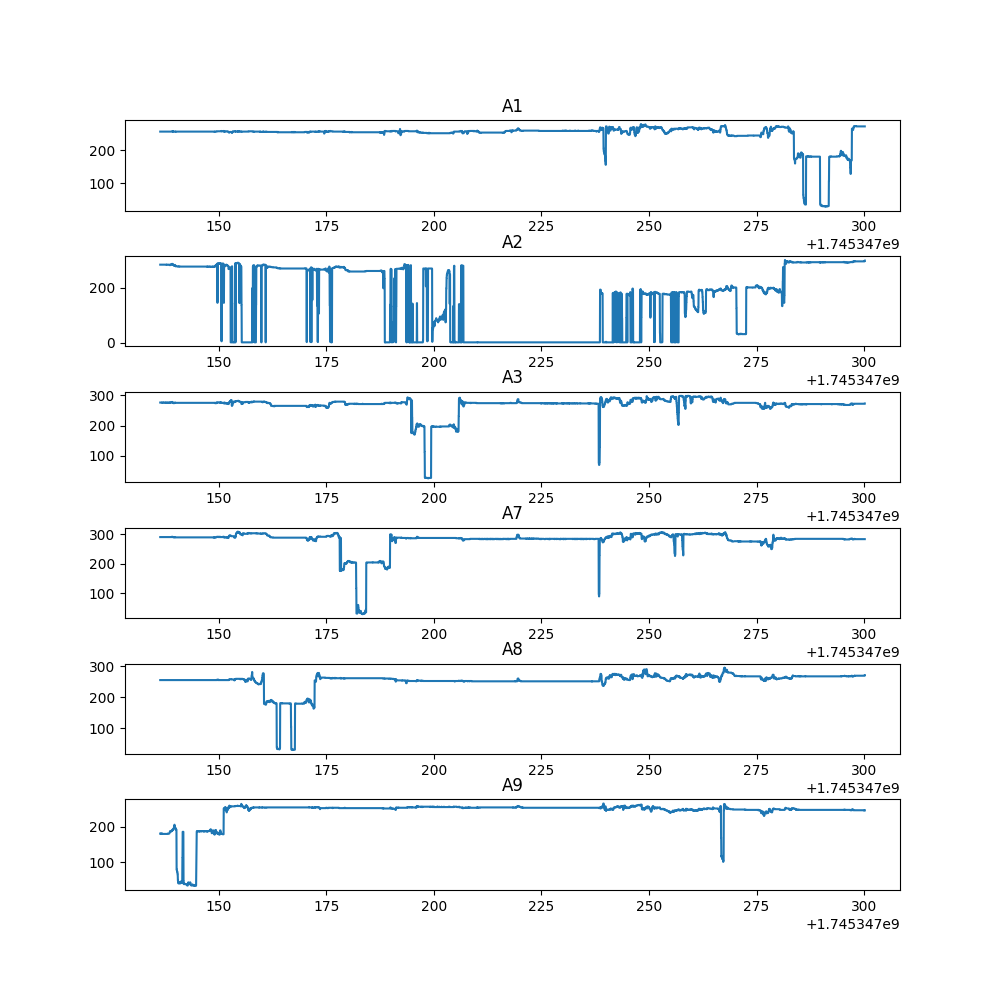

In [7]:
%matplotlib widget
fig, axes = plt.subplots(nrows=len(data_by_animal.keys()), figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for idx,(animal, data) in enumerate(data_by_animal.items()):
    axes[idx].plot(data['time_data'], data['cap_data'])
    axes[idx].set(title=animal)

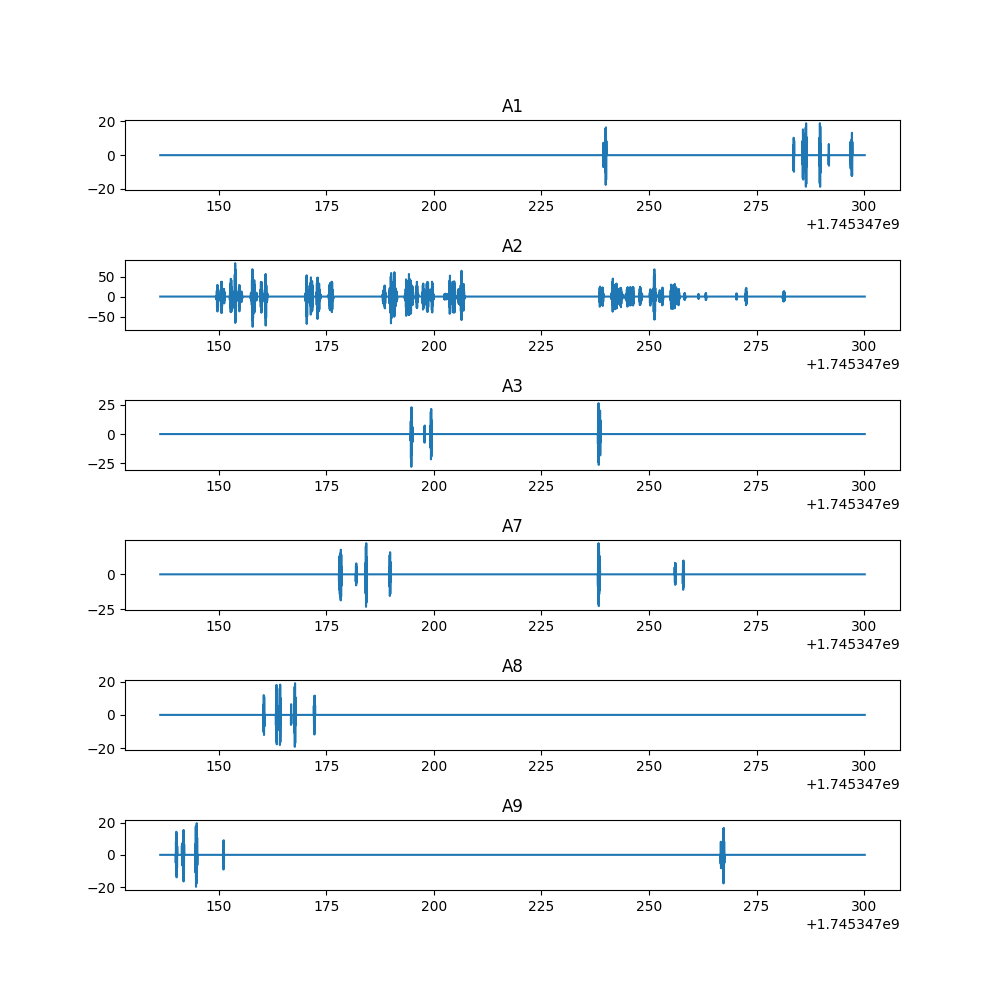

In [18]:
%matplotlib widget
fig, axes = plt.subplots(nrows=len(data_by_animal.keys()), figsize=(10,10))
plt.subplots_adjust(hspace=1)
for idx, (animal,data) in enumerate(data_by_animal.items()):
    b, a = ssignal.butter(4, [8, 12], btype='bandpass', fs=data['fs'])
    filtered_data = ssignal.filtfilt(b, a, data['cap_data'])
    filtered_data = [0 if np.abs(x) < 5 else x for x in filtered_data]
    data['filtered_data'] = filtered_data
    axes[idx].plot(data['time_data'], data['filtered_data'])
    axes[idx].set(title=animal)
